# **Imports**

In [25]:
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer

In [1]:
!pip install datasets
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.

Using data from **huggingface** dataset

In [2]:
# i will use emotion from it
from datasets import load_dataset
emotions = load_dataset("emotion")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [3]:
emotions  #emotions have 3 sets like you ask (train:16000 ,validation:2000 ,test : 2000)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
# i will pass train data to train_data
train_data=emotions['train']

In [6]:
# i will use feature  to know more information about data as U see ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
train_data.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [7]:
# try to see the first 5 elements in data
train_data[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

# **Convert data to DataFrames**

In [9]:
emotions.set_format(type="pandas")
df = emotions["train"][:]

In [10]:
# see head of data
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


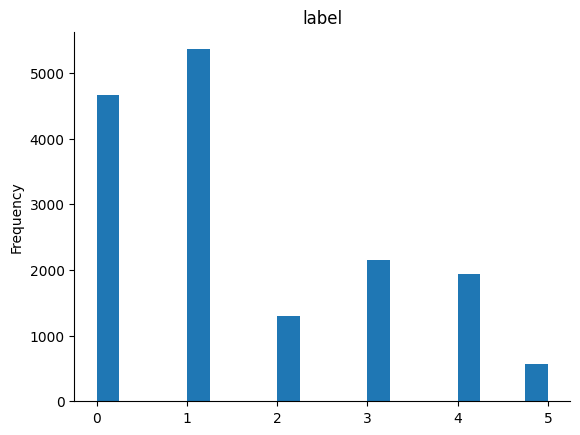

In [23]:
# @title data
df['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [13]:
# make label name to undersand the data
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)

In [15]:
#see head of data to make sure everything is okay
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


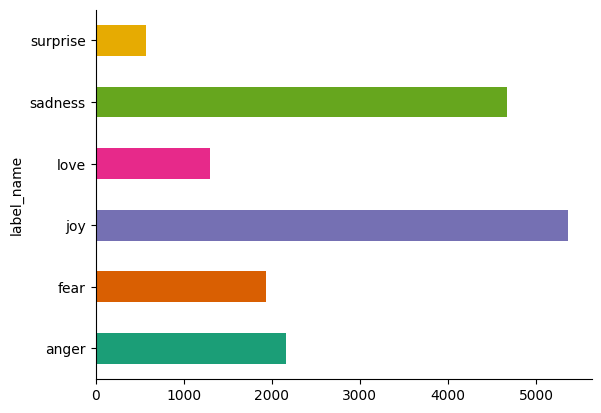

In [24]:
# @title emotions
df.groupby('label_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [54]:
#to make it usabel to use with tokens
emotions.reset_format()

# **Tokens**

In [55]:
# Define the model checkpoint to use a pre-trained DistilBERT model
model_ckpt = "distilbert-base-uncased"

# Load the tokenizer corresponding to the pre-trained DistilBERT model
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [56]:
# Define a function to tokenize a batch of text data
# Use the tokenizer to process the text data
# The 'padding=True' argument pads the sequences to the same length
# The 'truncation=True' argument truncates sequences to the maximum length allowed by the model
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

Apply the `tokenize` function to the `emotions` dataset using the `map` method.
The `batched=True` argument allows the `tokenize` function to process multiple examples at once, improving efficiency by batching the tokenization process.
Setting `batch_size=None` means that the entire dataset will be processed in a single batch. The result is an updated dataset with tokenized inputs, where each example is now tokenized and padded as needed.

In [57]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [58]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


# **Model Initialization**

In [61]:
from transformers import AutoModel
import torch

model_ckpt = "distilbert-base-uncased"
## Determine if a GPU is available; if so, set the device to CUDA (GPU), otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Load the pre-trained model specified by `model_ckpt`
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:  94%|#########3| 252M/268M [00:00<?, ?B/s]

In [64]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [66]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

In [67]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [62]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [88]:
from huggingface_hub import notebook_login

notebook_login()

In [89]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    log_level="error"
)



/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [92]:
from transformers import AutoModelForSequenceClassification

# Replace the original model loading with AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=len(label2id))

# Rest of your code remains the same
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)

In [ ]:
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.832000,0.312153,0.913000,0.912156


In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)

In [ ]:
# Evaluate RoBERTa
preds_output_roberta = trainer_roberta.predict(emotions_encoded_roberta["validation"])
metrics_roberta = preds_output_roberta.metrics
print("RoBERTa Metrics:", metrics_roberta)

# Evaluate DistilBERT (assuming 'preds_output' is available)
metrics_distilbert = preds_output.metrics
print("DistilBERT Metrics:", metrics_distilbert)

In [ ]:
# Compare metrics
print("Comparison of Metrics:")
#comparing the test accuracy.
print("Accuracy - DistilBERT:", metrics_distilbert["test_accuracy"], ", RoBERTa:", metrics_roberta["test_accuracy"])

In [ ]:
print("F1 Score - DistilBERT:", metrics_distilbert.keys(), ", RoBERTa:", metrics_roberta.keys())